In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib as plt
import requests
from urllib.parse import urlencode 
from datetime import timedelta
import json
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import calendar

# ШАГ 1. Считывание данных из яндекс диска и анализ данных

In [2]:
#пример взят из https://eddydewrussia.ru/2022/06/13/kak-prochest-csv-fajl-s-jandeks-diska-v-pandasa/
def get_df_yadisk(public_key): # функция считывания данных
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'  
    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    # загружаем файл в df 
    download_response = requests.get(download_url)
    if '404' in download_response:
        return download_response
    else:
        return pd.read_csv(download_url, sep=',') 

In [3]:
# изменение типа данных времени
olist_customers_dataset = get_df_yadisk('https://disk.yandex.ru/d/FUi5uSd6BfG_ig')
olist_orders_dataset = get_df_yadisk('https://disk.yandex.ru/d/t9Li4JOfgxuUrg')
olist_orders_dataset['order_purchase_timestamp'] = pd.to_datetime(olist_orders_dataset['order_purchase_timestamp'])
olist_orders_dataset['order_approved_at'] = pd.to_datetime(olist_orders_dataset['order_approved_at'])
olist_orders_dataset['order_delivered_carrier_date'] = pd.to_datetime(olist_orders_dataset['order_delivered_carrier_date'])
olist_orders_dataset['order_delivered_customer_date'] = pd.to_datetime(olist_orders_dataset['order_delivered_customer_date'])
olist_orders_dataset['order_estimated_delivery_date'] = pd.to_datetime(olist_orders_dataset['order_estimated_delivery_date'])
olist_order_items_dataset = get_df_yadisk('https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw')
olist_order_items_dataset['shipping_limit_date'] = pd.to_datetime(olist_order_items_dataset['shipping_limit_date'])

KeyError: 'href'

Анализ данных таблиц показал, что покупкой будут считаться записи в таблице `olist_orders_dataset` со статусами заказа `invoiced`, `shipped` и `delivered`. Данная теория основывается на появлении записи в колонке `order_approved_at`(время подтверждения оплаты заказа или дословный перевод "заказ одобренный в"). Появление значений в данной колонке появляется в статусе заказа `approved` (если представить онлайн приложение), когда пользователь нажимает кнопку *ОПЛАТИТЬ*, и транзакция проходит, статус заказа становится `approved`. После чего нужно понять каким образом статус заказа становится `unavailable`. Вероятнее всего, статус заказа становится `unavailable`, когда во время сборки заказа нужного товара нет, и тем самым транзакция откатывается, т.е. возвращает пользователю деньги. Если все товары присутствуют, статус заказа становится `invoiced`, покупателю, предположительно, на почту, приходит сообщение о том, что его заказ успешно оплачен и готов к транспортировке. С этого момента можно считать, что заказ является **покупкой**. Предполагаемый алгоритм последовательности статусов заказа: 

![Alt-текст](alg_status.JPG "алгоритм последовательности статусов")

Были найдены строки в таблице `olist_orders_dataset` со значением **NaT** в колонке `order_approved_at`. Предполагаю что данные заказы, являются **подарками** от магазина, поэтому есть информация о их доставке, но нет информации об оплате товара. Такие строки **покупкой** являться не будут.

# ШАГ 2 ВЫПОЛНЕНИЕ ЗАДАНИЙ.

## Задание 1 (Сколько у нас пользователей, которые совершили покупку только один раз?)

In [4]:
# выбирает строки с покупками
orders_purchases =  olist_orders_dataset.query("(order_status == 'invoiced' or order_status == 'shipped' or order_status == 'delivered') and order_approved_at.notnull()") \
.reset_index() \
.iloc[:,1:]
orders_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97885 entries, 0 to 97884
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97885 non-null  object        
 1   customer_id                    97885 non-null  object        
 2   order_status                   97885 non-null  object        
 3   order_purchase_timestamp       97885 non-null  datetime64[ns]
 4   order_approved_at              97885 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97569 non-null  datetime64[ns]
 6   order_delivered_customer_date  96456 non-null  datetime64[ns]
 7   order_estimated_delivery_date  97885 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.0+ MB


In [5]:
#  Объединение таблицы с уникальными идентификаторами пользователей и таблицы заказов
join_customers_orders = olist_customers_dataset.merge(orders_purchases, how = 'inner', on='customer_id')
join_customers_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97885 entries, 0 to 97884
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    97885 non-null  object        
 1   customer_unique_id             97885 non-null  object        
 2   customer_zip_code_prefix       97885 non-null  int64         
 3   customer_city                  97885 non-null  object        
 4   customer_state                 97885 non-null  object        
 5   order_id                       97885 non-null  object        
 6   order_status                   97885 non-null  object        
 7   order_purchase_timestamp       97885 non-null  datetime64[ns]
 8   order_approved_at              97885 non-null  datetime64[ns]
 9   order_delivered_carrier_date   97569 non-null  datetime64[ns]
 10  order_delivered_customer_date  96456 non-null  datetime64[ns]
 11  order_estimated

In [6]:
#  Объединение таблицы с уникальными идентификаторами пользователей и таблицы заказов
join_customers_orders = olist_customers_dataset.merge(orders_purchases, how = 'inner', on='customer_id')
join_customers_orders.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [7]:
# количество совершенных покупок каждым пользователем
count_all_purchases = join_customers_orders.groupby('customer_unique_id').count() \
                     .sort_values('customer_id').reset_index().rename(columns={'customer_id': 'count_purchase'})[['customer_unique_id','count_purchase']]

In [8]:
count_all_purchases.count_purchase.value_counts()

1     91809
2      2642
3       185
4        29
5         9
6         5
7         3
16        1
9         1
Name: count_purchase, dtype: int64

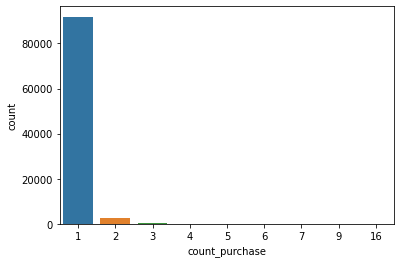

In [9]:
sn.countplot(x = 'count_purchase', data = count_all_purchases)

#### Вывод из задания 1:
Колличество пользователей совершившие один заказ равно **91809**. 

## Задание 2 (Сколько заказов в месяц в среднем не доставляется по разным причинам?)

In [10]:
# Отбираем данные по которым заказы были отменены или недоступны. 
# Отменённые заказы обязательно болжны быть оплачены, так как нас интерисуют недоставленные заказы.
orders_not_delivered  = olist_orders_dataset[((olist_orders_dataset.order_status == 'unavailable') | (olist_orders_dataset.order_status == 'canceled')) & (olist_orders_dataset.order_approved_at.notna())]
orders_not_delivered.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1093 entries, 266 to 99415
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       1093 non-null   object        
 1   customer_id                    1093 non-null   object        
 2   order_status                   1093 non-null   object        
 3   order_purchase_timestamp       1093 non-null   datetime64[ns]
 4   order_approved_at              1093 non-null   datetime64[ns]
 5   order_delivered_carrier_date   75 non-null     datetime64[ns]
 6   order_delivered_customer_date  6 non-null      datetime64[ns]
 7   order_estimated_delivery_date  1093 non-null   datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 76.9+ KB


In [11]:
# все отменённые заказы со статусом unavailable
df_unavailable = orders_not_delivered[orders_not_delivered.order_status == 'unavailable']
df_unavailable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 266 to 99415
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       609 non-null    object        
 1   customer_id                    609 non-null    object        
 2   order_status                   609 non-null    object        
 3   order_purchase_timestamp       609 non-null    datetime64[ns]
 4   order_approved_at              609 non-null    datetime64[ns]
 5   order_delivered_carrier_date   0 non-null      datetime64[ns]
 6   order_delivered_customer_date  0 non-null      datetime64[ns]
 7   order_estimated_delivery_date  609 non-null    datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 42.8+ KB


In [12]:
# заказы со статусом unavailable не имеющие товаров в таблице olist_order_items_dataset
df2 = olist_order_items_dataset.merge(df_unavailable, how='right', on='order_id')
df2[~(df2.order_item_id.notnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 0 to 609
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       603 non-null    object        
 1   order_item_id                  0 non-null      float64       
 2   product_id                     0 non-null      object        
 3   seller_id                      0 non-null      object        
 4   shipping_limit_date            0 non-null      datetime64[ns]
 5   price                          0 non-null      float64       
 6   freight_value                  0 non-null      float64       
 7   customer_id                    603 non-null    object        
 8   order_status                   603 non-null    object        
 9   order_purchase_timestamp       603 non-null    datetime64[ns]
 10  order_approved_at              603 non-null    datetime64[ns]
 11  order_delivered_car

In [13]:
# заказы со статусом unavailable имеющие товаров в таблице olist_order_items_dataset
df2[(df2.order_item_id.notnull())]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
194,dc18a044b56ed174037ca164cdf2e921,1.0,faa268ecc8a8434cb4ebee091b3222d6,f0563bacf40c311f1c4d3d6b67b8a7a7,2016-10-21 16:18:52,1199.00,28.78,4a06381959b6670756de02e07b83815f,unavailable,2016-10-05 14:16:28,2016-10-06 15:56:49,NaT,NaT,2016-11-29
304,4dd47e84e6b8ff4a63d0b8425e6d788e,1.0,2aa489c905e1d41d8c716a6d6912d8c2,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 01:09:09,299.90,13.68,96bbcbc8372c86da857d842dfda6bd72,unavailable,2016-10-06 23:49:18,2016-10-07 01:09:08,NaT,NaT,2016-11-24
361,3c3ca08854ca922fe8e9cedfd6841c8a,1.0,ac6c24af9f913c9375a3ea77883bda6e,5206cc4bc2297c833e6061c49bf9c43f,2016-10-12 13:21:35,35.00,10.96,88c36fbd3df96094f90f0315e1d2dd90,unavailable,2016-10-08 12:13:38,2016-10-08 13:21:35,NaT,NaT,2016-11-30
368,54bb06e1ca86bd99ee2a8d6288bf4ede,1.0,bef13288a0f8b26d763411ced1dfa268,cf281cf8b7affbdfe751b29cc85580e1,2016-10-29 09:43:46,64.90,25.33,98bfbf477ed9f40a0264f5e527a446be,unavailable,2016-10-06 13:38:39,2016-10-06 14:22:19,NaT,NaT,2016-12-12
479,1a47da1d66c70489c8e35fe2b5433ab7,1.0,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 18:53:48,249.90,20.85,3d8e326c3cef3a9bba7ca121baac5fc3,unavailable,2016-10-07 18:16:31,2016-10-07 18:53:48,NaT,NaT,2016-12-07
515,2fd1c83dd4714cf3cf796fffb6c8de62,1.0,17c7ec33a1657924ad493e6978b4bf91,3d01d1c414c44b5943a09619ff3853cb,2016-10-10 15:55:42,99.00,9.12,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29
516,2fd1c83dd4714cf3cf796fffb6c8de62,2.0,966a067b38634929844120e39b1576bc,61f159ef6da2d441951d2c0efa719362,2016-10-10 15:55:41,59.99,24.08,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29


In [14]:
# все отменённые и доставленные заказы со статусом canceled
orders_delivere_canceled = orders_not_delivered[(orders_not_delivered.order_delivered_customer_date.notnull()) \
                     & (orders_not_delivered.order_status != 'unavailable')]
orders_delivere_canceled

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


In [15]:
# все отменённые и не доставленные заказы со статусом canceled
df_canceled = orders_not_delivered[(~orders_not_delivered.order_delivered_customer_date.notnull()) \
                     & (orders_not_delivered.order_status != 'unavailable')]
df_canceled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 397 to 99143
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       478 non-null    object        
 1   customer_id                    478 non-null    object        
 2   order_status                   478 non-null    object        
 3   order_purchase_timestamp       478 non-null    datetime64[ns]
 4   order_approved_at              478 non-null    datetime64[ns]
 5   order_delivered_carrier_date   69 non-null     datetime64[ns]
 6   order_delivered_customer_date  0 non-null      datetime64[ns]
 7   order_estimated_delivery_date  478 non-null    datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 33.6+ KB


In [16]:
orders_not_delivered['order_approved_at_month'] = orders_not_delivered['order_approved_at'].dt.month
orders_not_delivered['order_approved_at_year'] = orders_not_delivered['order_approved_at'].dt.year
orders_not_delivered_month_year = orders_not_delivered[['order_approved_at_month','order_approved_at_year','order_id']]

In [17]:
# колличество отменённых заказов по годам и месяцам
orders_not_delivered_month = orders_not_delivered_month_year.groupby(['order_approved_at_year','order_approved_at_month'])\
                                .count().reset_index().rename(columns={'order_id':'count_year_month'})
orders_not_delivered_month.head(5)

,order_approved_at_year,order_approved_at_month,count_year_month
0,2016,10,26
1,2017,1,10
2,2017,2,62
3,2017,3,63
4,2017,4,22


In [18]:
# среднее колличество отменённых заказов по месяцам
orders_not_delivered_month.groupby('order_approved_at_month').agg({'count_year_month': 'mean'})

,count_year_month
order_approved_at_month,
1,44.5
2,82.0
3,51.0
4,21.0
5,45.5
6,30.0
7,63.0
8,48.5
9,53.0


#### Вывод из задания 2:
Общее количество недоставленных заказов составило **1093** ед.

**609** товаров были заказаны, но недоступны. Из них: 
 - **603** отсутствует товар у продовцов
 - **6** присутствует товар у продовцов. Вероятнее всего товар ненадлежащего качества.

**6** заказов были доставлены но отменены из них:
 - покупатель `6a04c8339c44b23e189446216a494569` c заказом `1950d777989f6a877539f53795b4c3c3`скорее всего отказался от заказа в связи с его опознанием на 12 дней. Обещали доставить 09-03-2018, а доставили 21-03-2018
 - оставшиеся **5** доставлены вовремя. Вероятнее всего, товар был доставлен в ненадлежащем виде.

**478** заказов были отменены пользователями

## Задание 3 (По каждому товару определить, в какой день недели товар чаще всего покупается.)


In [19]:
# объединение купленных заказов с товарами в них
items_purchases = orders_purchases.merge(olist_order_items_dataset, how='inner', on='order_id')
items_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111726 entries, 0 to 111725
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       111726 non-null  object        
 1   customer_id                    111726 non-null  object        
 2   order_status                   111726 non-null  object        
 3   order_purchase_timestamp       111726 non-null  datetime64[ns]
 4   order_approved_at              111726 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111365 non-null  datetime64[ns]
 6   order_delivered_customer_date  110174 non-null  datetime64[ns]
 7   order_estimated_delivery_date  111726 non-null  datetime64[ns]
 8   order_item_id                  111726 non-null  int64         
 9   product_id                     111726 non-null  object        
 10  seller_id                      111726 non-null  object        
 11  

In [20]:
 # Выбираем нужные данные
items_purchases_need = items_purchases[['product_id','order_approved_at']]

In [21]:
 # Добавляем колонку с именем дня недели относительно времени подтверждения оплаты заказа
items_purchases_need['name_day_of_week'] = items_purchases_need.order_approved_at.dt.day_name()
items_purchases_need

,product_id,order_approved_at,name_day_of_week
0,87285b34884572647811a353c7ac498a,2017-10-02 11:07:15,Monday
1,595fac2a385ac33a80bd5114aec74eb8,2018-07-26 03:24:27,Thursday
2,aa4383b373c6aca5d8797843e5594415,2018-08-08 08:55:23,Wednesday
3,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-18 19:45:59,Saturday
4,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-13 22:20:29,Tuesday
...,...,...,...
111721,f1d4ce8c6dd66c47bbaa8c6781c2a923,2018-02-06 13:10:37,Tuesday
111722,b80910977a37536adeddd63663f916ad,2017-08-27 15:04:16,Sunday
111723,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-08 21:36:21,Monday
111724,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-08 21:36:21,Monday


In [22]:
# Подсчет колличества проданых товаров по дням недеи и ID товара
count_purchase_items_need = items_purchases_need.groupby(['product_id','name_day_of_week'], as_index=False).count() \
                    .rename(columns={'order_approved_at':'count_purchase_items'}) 
count_purchase_items_need

,product_id,name_day_of_week,count_purchase_items
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
60541,fff9553ac224cec9d15d49f5a263411f,Saturday,1
60542,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
60543,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
60544,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,3


In [23]:
# Ищем максимальное колличество проданых товаров в один из дней недели  
max_purchase_items_need = count_purchase_items_need.groupby(['product_id'], as_index=False).agg({'count_purchase_items':'max'})
max_purchase_items_need

,product_id,count_purchase_items
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,1
4,000d9be29b5207b54e86aa1b1ac54872,1
...,...,...
32539,fff6177642830a9a94a0f2cba5e476d1,1
32540,fff81cc3158d2725c0655ab9ba0f712c,1
32541,fff9553ac224cec9d15d49f5a263411f,1
32542,fffdb2d0ec8d6a61f0a0a0db3f25b441,3


In [24]:
# дни недели по товаром с учетом единичных покупок. 
max_count_items_on_name_day_week = max_purchase_items_need.merge(count_purchase_items_need, how='inner', on=['product_id','count_purchase_items']).sort_values('count_purchase_items', ascending=False)
max_count_items_on_name_day_week

,product_id,count_purchase_items,name_day_of_week
28209,aca2eb7d00ea1a7b8ebd4e68314663af,119,Tuesday
13901,53b36df67ebb7c41585e8d54d6772e08,105,Tuesday
11040,422879e10f46682990de24d770e7f83d,89,Tuesday
25180,99a4788cb24856965c36a24e339b6058,82,Tuesday
9045,368c6c730842d78016ad823897a372db,80,Thursday
...,...,...,...
16077,6157bc1be1e8edc531fc0c94dddf5ac9,1,Sunday
16076,6157bc1be1e8edc531fc0c94dddf5ac9,1,Friday
16075,6156141755987eaf93bc9b959601db45,1,Thursday
16071,614dd74b96d1a51792de2d9a3475145a,1,Thursday


In [25]:
# дни недели по товаром без учета единичных покупок.
max_count_items_on_name_day_week[max_count_items_on_name_day_week.count_purchase_items > 1]

,product_id,count_purchase_items,name_day_of_week
28209,aca2eb7d00ea1a7b8ebd4e68314663af,119,Tuesday
13901,53b36df67ebb7c41585e8d54d6772e08,105,Tuesday
11040,422879e10f46682990de24d770e7f83d,89,Tuesday
25180,99a4788cb24856965c36a24e339b6058,82,Tuesday
9045,368c6c730842d78016ad823897a372db,80,Thursday
...,...,...,...
7663,2da57168cd8fff36cb88b21369ce7e6d,2,Monday
41898,feb94d995efca232513a7baffff772b8,2,Thursday
41737,fdbfd4cec6db6e89f22d9aa2c4839eed,2,Tuesday
35732,d8aed41af112033ae4733abcf1f206fc,2,Monday


#### Вывод из задания 3:
`aca2eb7d00ea1a7b8ebd4e68314663af` самый продаваемый продукт по вторникам

## Задание 4 (Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?)


In [26]:
# Объединения покупок и пользователей
orders_customer_purchases = orders_purchases.merge(olist_customers_dataset, how='inner', on='customer_id' )
orders_customer_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97885 entries, 0 to 97884
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97885 non-null  object        
 1   customer_id                    97885 non-null  object        
 2   order_status                   97885 non-null  object        
 3   order_purchase_timestamp       97885 non-null  datetime64[ns]
 4   order_approved_at              97885 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97569 non-null  datetime64[ns]
 6   order_delivered_customer_date  96456 non-null  datetime64[ns]
 7   order_estimated_delivery_date  97885 non-null  datetime64[ns]
 8   customer_unique_id             97885 non-null  object        
 9   customer_zip_code_prefix       97885 non-null  int64         
 10  customer_city                  97885 non-null  object        
 11  customer_state 

In [27]:
# выбираем нужные столбцы
orders_customer_purchases = orders_customer_purchases[['customer_unique_id','order_approved_at', ]]
orders_customer_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97885 entries, 0 to 97884
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_unique_id  97885 non-null  object        
 1   order_approved_at   97885 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 2.2+ MB


In [28]:
# приводим дату оплаты покупки к началу месяца 
orders_customer_purchases['order_approved_mounth'] = orders_customer_purchases['order_approved_at'].astype('datetime64[M]')
orders_customer_purchases

,customer_unique_id,order_approved_at,order_approved_mounth
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,2017-10-01
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,2018-07-01
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,2018-08-01
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,2017-11-01
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29,2018-02-01
...,...,...,...
97880,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,2017-03-01
97881,da62f9e57a76d978d02ab5362c509660,2018-02-06 13:10:37,2018-02-01
97882,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 15:04:16,2017-08-01
97883,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:36:21,2018-01-01


In [29]:
# Групируем данные по ID  клиента и дате приведённой к началу месяца(по сути это группировка одновременно по году и месяцу и ID), и считаем количество покупок совершенное пользователем в определенный месяц 
orders_customer_purchases_count_month = orders_customer_purchases.groupby(['customer_unique_id','order_approved_mounth']).count() \
                        .sort_values('order_approved_at') \
                        .reset_index()
orders_customer_purchases_count_month

,customer_unique_id,order_approved_mounth,order_approved_at
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1
1,a9e4348b76f85861ada324e72dc92aca,2017-12-01,1
2,a9e30a7260591d7af904d38ec41d449b,2018-02-01,1
3,a9e21dbc0a0e69348c3895c18f8d8d60,2018-08-01,1
4,a9e15fa88ea3281c6a02637482d74f42,2018-05-01,1
...,...,...,...
96545,b4e4f24de1e8725b74e4a1f4975116ed,2018-02-01,4
96546,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,4
96547,3e43e6105506432c953e165fb2acf44c,2018-02-01,4
96548,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,4


In [30]:
# Получаем количество дней в месяце
orders_customer_purchases_count_month['count_day_in_mounth'] = orders_customer_purchases_count_month.order_approved_mounth.apply(lambda x: calendar.monthrange(int(str(x).split('-')[0]),int(str(x).split('-')[1]))[1])
orders_customer_purchases_count_month

,customer_unique_id,order_approved_mounth,order_approved_at,count_day_in_mounth
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,31
1,a9e4348b76f85861ada324e72dc92aca,2017-12-01,1,31
2,a9e30a7260591d7af904d38ec41d449b,2018-02-01,1,28
3,a9e21dbc0a0e69348c3895c18f8d8d60,2018-08-01,1,31
4,a9e15fa88ea3281c6a02637482d74f42,2018-05-01,1,31
...,...,...,...,...
96545,b4e4f24de1e8725b74e4a1f4975116ed,2018-02-01,4,28
96546,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,4,28
96547,3e43e6105506432c953e165fb2acf44c,2018-02-01,4,28
96548,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,4,30


In [31]:
# получаем сколько недель в месяце
orders_customer_purchases_count_month['count_weeks_in_mounth'] = orders_customer_purchases_count_month.count_day_in_mounth \
            .apply(lambda x: int(((x * 4) / 28) * 100) / 100)
orders_customer_purchases_count_month

,customer_unique_id,order_approved_mounth,order_approved_at,count_day_in_mounth,count_weeks_in_mounth
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,31,4.42
1,a9e4348b76f85861ada324e72dc92aca,2017-12-01,1,31,4.42
2,a9e30a7260591d7af904d38ec41d449b,2018-02-01,1,28,4.00
3,a9e21dbc0a0e69348c3895c18f8d8d60,2018-08-01,1,31,4.42
4,a9e15fa88ea3281c6a02637482d74f42,2018-05-01,1,31,4.42
...,...,...,...,...,...
96545,b4e4f24de1e8725b74e4a1f4975116ed,2018-02-01,4,28,4.00
96546,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,4,28,4.00
96547,3e43e6105506432c953e165fb2acf44c,2018-02-01,4,28,4.00
96548,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,4,30,4.28


In [32]:
# получаем среднее коллчество совешенных покупок пользователем в неделю по месяцам.
orders_customer_purchases_count_month['mean_amount_shop_in_week_on_month'] = round(orders_customer_purchases_count_month.order_approved_at / orders_customer_purchases_count_month.count_weeks_in_mounth, 3)
orders_customer_purchases_count_month[['customer_unique_id','order_approved_mounth','mean_amount_shop_in_week_on_month']]

,customer_unique_id,order_approved_mounth,mean_amount_shop_in_week_on_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,0.226
1,a9e4348b76f85861ada324e72dc92aca,2017-12-01,0.226
2,a9e30a7260591d7af904d38ec41d449b,2018-02-01,0.250
3,a9e21dbc0a0e69348c3895c18f8d8d60,2018-08-01,0.226
4,a9e15fa88ea3281c6a02637482d74f42,2018-05-01,0.226
...,...,...,...
96545,b4e4f24de1e8725b74e4a1f4975116ed,2018-02-01,1.000
96546,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,1.000
96547,3e43e6105506432c953e165fb2acf44c,2018-02-01,1.000
96548,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,0.935


In [33]:
orders_customer_purchases_count_month.sort_values('mean_amount_shop_in_week_on_month')

,customer_unique_id,order_approved_mounth,order_approved_at,count_day_in_mounth,count_weeks_in_mounth,mean_amount_shop_in_week_on_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,31,4.42,0.226
55662,3e5306add1209e5ba184092dd1587282,2018-01-01,1,31,4.42,0.226
55664,3e5306add1209e5ba184092dd1587282,2017-01-01,1,31,4.42,0.226
55665,3e52cdb7a848261e1c2de77e50a88995,2018-05-01,1,31,4.42,0.226
55666,3e52ccb0647aeef840516366342ffed8,2018-03-01,1,31,4.42,0.226
...,...,...,...,...,...,...
96542,25a560b9a6006157838aab1bdbd68624,2017-04-01,4,30,4.28,0.935
96545,b4e4f24de1e8725b74e4a1f4975116ed,2018-02-01,4,28,4.00,1.000
96546,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,4,28,4.00,1.000
96547,3e43e6105506432c953e165fb2acf44c,2018-02-01,4,28,4.00,1.000


#### Вывод из задания 4:
Только 1 пользоваталь (`12f5d6e1cbf93dafd9dcc19095df0b3d`) в среднем совершил больше одной покупки в неделю в январе 2017 года

## Задание 5 (Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.)

In [34]:
# Объединения покупок и пользователей
orders_customer_purchases = orders_purchases.merge(olist_customers_dataset, how='inner', on='customer_id' )
orders_customer_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97885 entries, 0 to 97884
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97885 non-null  object        
 1   customer_id                    97885 non-null  object        
 2   order_status                   97885 non-null  object        
 3   order_purchase_timestamp       97885 non-null  datetime64[ns]
 4   order_approved_at              97885 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97569 non-null  datetime64[ns]
 6   order_delivered_customer_date  96456 non-null  datetime64[ns]
 7   order_estimated_delivery_date  97885 non-null  datetime64[ns]
 8   customer_unique_id             97885 non-null  object        
 9   customer_zip_code_prefix       97885 non-null  int64         
 10  customer_city                  97885 non-null  object        
 11  customer_state 

In [35]:
# Преобразование данных и выявление какой промежуток времени взять
orders_customer_purchases = orders_customer_purchases[['customer_unique_id','order_id','order_approved_at']]
orders_customer_purchases['order_approved_mounth'] = orders_customer_purchases['order_approved_at'].astype('datetime64[M]')
orders_customer_purchases['order_approved_mounth'].value_counts().sort_index()

2016-09-01       1
2016-10-01     292
2016-12-01       1
2017-01-01     742
2017-02-01    1671
2017-03-01    2602
2017-04-01    2341
2017-05-01    3618
2017-06-01    3202
2017-07-01    3888
2017-08-01    4278
2017-09-01    4227
2017-10-01    4491
2017-11-01    7255
2017-12-01    5747
2018-01-01    7079
2018-02-01    6598
2018-03-01    7240
2018-04-01    6752
2018-05-01    7018
2018-06-01    6142
2018-07-01    6124
2018-08-01    6575
2018-09-01       1
Name: order_approved_mounth, dtype: int64

В рамках дальнейшего выполнения задания, будет взят промежуток **2017** года, в связи тем, что только у данного года есть покупки с января по декабрь.

In [36]:
# получаем покупки за 2017 год
orders_customer_purchases_2017 = orders_customer_purchases[(orders_customer_purchases.order_approved_mounth >= '2017-01-01') & (orders_customer_purchases.order_approved_mounth < '2018-01-01')]
orders_customer_purchases_2017

,customer_unique_id,order_id,order_approved_at,order_approved_mounth
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,2017-10-01
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,2017-11-01
5,80bb27c7c16e8f973207a5086ab329e2,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09 22:10:13,2017-07-01
6,36edbb3fb164b1f16485364b6fb04c73,136cce7faa42fdb2cefd53fdc79a6098,2017-04-13 13:25:17,2017-04-01
7,932afa1e708222e5821dac9cd5db4cae,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:22:11,2017-05-01
...,...,...,...,...
97877,c716cf2b5b86fb24257cffe9e7969df8,9115830be804184b91f5c00f6f49f92d,2017-10-04 20:07:14,2017-10-01
97878,e03dbdf5e56c96b106d8115ac336f47f,aa04ef5214580b06b10e2a378300db44,2017-01-27 01:05:25,2017-01-01
97879,831ce3f1bacbd424fc4e38fbd4d66d29,880675dff2150932f1601e1c07eadeeb,2017-02-23 09:15:11,2017-02-01
97880,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,2017-03-01


In [37]:
# получаеминформацию о первой покупки каждого пользователя
first_shop_customer = orders_customer_purchases_2017.groupby('customer_unique_id')['order_approved_mounth'].min().reset_index()
first_shop_customer

,customer_unique_id,order_approved_mounth
0,0000f46a3911fa3c0805444483337064,2017-03-01
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01
2,0004aac84e0df4da2b147fca70cf8255,2017-11-01
3,0005e1862207bf6ccc02e4228effd9a0,2017-03-01
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-01
...,...,...
42722,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-01
42723,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01
42724,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01
42725,ffff371b4d645b6ecea244b27531430a,2017-02-01


In [38]:
# составляем календарь от первого заказа до поледнего
min_date = orders_customer_purchases_2017['order_approved_mounth'].min()
max_date = orders_customer_purchases_2017['order_approved_mounth'].max()
month = pd.DataFrame(pd.date_range(min_date,max_date,freq='MS'))
month.rename(columns={0:'monht'}, inplace = True)
month

,monht
0,2017-01-01
1,2017-02-01
2,2017-03-01
3,2017-04-01
4,2017-05-01
5,2017-06-01
6,2017-07-01
7,2017-08-01
8,2017-09-01
9,2017-10-01


In [39]:
#  создаём ключи для объединеия с календарём
first_shop_customer['key'] = 1
month['key'] = 1

In [40]:
# делаем CROSS JOIN
template = first_shop_customer.merge(month, on='key')[['customer_unique_id','order_approved_mounth','monht']]
template

,customer_unique_id,order_approved_mounth,monht
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-01-01
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-02-01
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01
...,...,...,...
512719,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-08-01
512720,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-09-01
512721,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-10-01
512722,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-11-01


In [41]:
# оставляем только те строки, где можем проследить, что делал пользователь каждый месяц после покупки первого товара
template = template[template['monht'] >= template['order_approved_mounth']]
template

,customer_unique_id,order_approved_mounth,monht
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01
5,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01
6,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01
...,...,...,...
512719,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-08-01
512720,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-09-01
512721,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-10-01
512722,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-11-01


In [42]:
#  Выявляем в каких месяцах и сколько раз пользователь совершил заказов. Оставляется нужные колонки
shops_month = orders_customer_purchases_2017.groupby(['customer_unique_id','order_approved_mounth'])['order_id'].count().reset_index()
shops_month.columns = ['customer_unique_id','monht','count_shops']
shops_month.sort_values('count_shops')

,customer_unique_id,monht,count_shops
0,0000f46a3911fa3c0805444483337064,2017-03-01,1
28759,a9eb99ccaa59fb6f67bdbb1ec6ca45e1,2017-09-01,1
28760,a9ee0ffb5493291751591e53992b1349,2017-12-01,1
28761,a9ee469c972af1c93ba404408894b0fa,2017-12-01,1
28762,a9ee8c86be5345e14f0bef96bf06c5b0,2017-06-01,1
...,...,...,...
22378,83e7958a94bd7f74a9414d8782f87628,2017-01-01,4
27438,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,4
6381,25a560b9a6006157838aab1bdbd68624,2017-04-01,4
29884,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,4


In [43]:
# Объединяем колличество и месяца после первой покупки, тем самым проверяем был ли пользователь активен после первой покупки
report = template.merge(shops_month, on=['customer_unique_id','monht'], how='left')
report

,customer_unique_id,order_approved_mounth,monht,count_shops
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,1.0
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01,NaN
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01,NaN
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01,NaN
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01,NaN
...,...,...,...,...
214855,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-08-01,NaN
214856,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-09-01,NaN
214857,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-10-01,NaN
214858,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-11-01,NaN


In [44]:
# заменяем NAN на 0
report['active'] = (report['count_shops'] > 0) * 1
report

,customer_unique_id,order_approved_mounth,monht,count_shops,active
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,1.0,1
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01,NaN,0
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01,NaN,0
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01,NaN,0
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01,NaN,0
...,...,...,...,...,...
214855,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-08-01,NaN,0
214856,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-09-01,NaN,0
214857,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-10-01,NaN,0
214858,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-11-01,NaN,0


In [45]:
# Для убодности разбиваем по месяцам, чтобы транспонировать таблицу и было удобнее её читать
report['lifetime'] = ((report['monht'] - report['order_approved_mounth']) / np.timedelta64(1, 'M')).round().astype(int)
report

,customer_unique_id,order_approved_mounth,monht,count_shops,active,lifetime
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,1.0,1,0
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01,NaN,0,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01,NaN,0,2
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01,NaN,0,3
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01,NaN,0,4
...,...,...,...,...,...,...
214855,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-08-01,NaN,0,3
214856,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-09-01,NaN,0,4
214857,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-10-01,NaN,0,5
214858,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-11-01,NaN,0,6


In [46]:
# Находит retantions
retantion = report.pivot_table(index='order_approved_mounth', columns='lifetime',values = 'active', aggfunc='mean')
retantion

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
order_approved_mounth,,,,,,,,,,,,
2017-01-01,1.0,0.005642,0.002821,0.001410,0.004231,0.001410,0.004231,0.001410,0.001410,0.000000,0.002821,0.002821
2017-02-01,1.0,0.002433,0.002433,0.001825,0.004258,0.001217,0.002433,0.001825,0.000608,0.001825,0.001217,NaN
2017-03-01,1.0,0.005086,0.003521,0.003521,0.003521,0.001565,0.001565,0.003130,0.002739,0.001174,NaN,NaN
2017-04-01,1.0,0.006111,0.002182,0.001746,0.002619,0.002619,0.003492,0.002619,0.003492,NaN,NaN,NaN
2017-05-01,1.0,0.005396,0.004828,0.003692,0.003124,0.003408,0.004260,0.001420,NaN,NaN,NaN,NaN
2017-06-01,1.0,0.004519,0.003551,0.003873,0.002582,0.003551,0.003551,NaN,NaN,NaN,NaN,NaN
2017-07-01,1.0,0.005308,0.003185,0.001858,0.003450,0.001858,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,1.0,0.006768,0.003626,0.002659,0.003626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,1.0,0.006623,0.004906,0.003434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


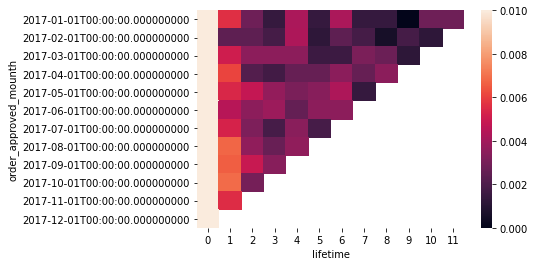

In [47]:
# строим график
sn.heatmap(retantion,vmin=0, vmax=0.01)

#### Вывод из задания 5:
Самый высокий retention  на 3й месяц имеет когорта **2017-06-01**

## Задание 6 ( Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. )

In [48]:
# Высчитываем общую цену каждого заказа
total_order_price= olist_order_items_dataset.groupby('order_id').agg({'price':'sum'}).reset_index()
total_order_price

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99
98662,fffcd46ef2263f404302a634eb57f7eb,350.00
98663,fffce4705a9662cd70adb13d4a31832d,99.90
98664,fffe18544ffabc95dfada21779c9644f,55.99


In [49]:
# объединяем суммы заказов с покупками (найдена ошибка нет 3 ценн)
join_price_orders = orders_purchases.merge(total_order_price, how='left', on='order_id')
join_price_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97885 entries, 0 to 97884
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97885 non-null  object        
 1   customer_id                    97885 non-null  object        
 2   order_status                   97885 non-null  object        
 3   order_purchase_timestamp       97885 non-null  datetime64[ns]
 4   order_approved_at              97885 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97569 non-null  datetime64[ns]
 6   order_delivered_customer_date  96456 non-null  datetime64[ns]
 7   order_estimated_delivery_date  97885 non-null  datetime64[ns]
 8   price                          97882 non-null  float64       
dtypes: datetime64[ns](5), float64(1), object(3)
memory usage: 7.5+ MB


In [50]:
# !!!!!Выявлена ошибка данных, по трем заказам нет данных в базе данных "olist_order_items_dataset"!!!!!
join_price_orders[join_price_orders.price.isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,price
22895,a68ce1686d536ca72bd2dadc4b8671e5,d7bed5fac093a4136216072abaf599d5,shipped,2016-10-05 01:47:40,2016-10-07 03:11:22,2016-11-07 16:37:37,NaT,2016-12-01,NaN
56687,2ce9683175cdab7d1c95bcbb3e36f478,b2d7ae0415dbbca535b5f7b38056dd1f,invoiced,2016-10-05 21:03:33,2016-10-06 07:46:39,NaT,NaT,2016-11-25,NaN
68834,e04f1da1f48bf2bbffcf57b9824f76e1,0d00d77134cae4c58695086ad8d85100,invoiced,2016-10-05 13:22:20,2016-10-06 15:51:38,NaT,NaT,2016-11-29,NaN


In [51]:
# объединяем суммы заказов с покупками 
join_price_orders = orders_purchases.merge(total_order_price, how='inner', on='order_id')[['order_id','customer_id','order_approved_at','price']]
join_price_orders

,order_id,customer_id,order_approved_at,price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,19.90
...,...,...,...,...
97877,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,72.00
97878,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 13:10:37,174.90
97879,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 15:04:16,205.99
97880,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:36:21,359.98


In [52]:
# Объединяем все 3 таблицы данных для дальнейши преобразваний
join_price_orders_customer = join_price_orders.merge(olist_customers_dataset, how = 'inner', on='customer_id')
join_price_orders_customer

,order_id,customer_id,order_approved_at,price,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,29.99,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,118.70,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,159.90,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,45.00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,19.90,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...
97877,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,72.00,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
97878,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 13:10:37,174.90,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
97879,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 15:04:16,205.99,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
97880,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:36:21,359.98,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [53]:
#  получаем по кадому пользователю сумму денежных средств потраченные за покупки(денежная стоимость), колличество(частота) совержшенных покупок, и дата последней покупки
count_money_sum = join_price_orders_customer.groupby('customer_unique_id').agg({'price':'sum','order_id':'count','order_approved_at':'max'}).reset_index()
count_money_sum

,customer_unique_id,price,order_id,order_approved_at
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,2018-05-10 11:11:18
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,2018-05-07 18:25:44
2,0000f46a3911fa3c0805444483337064,69.00,1,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,2017-10-12 20:49:17
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,2017-11-14 20:06:52
...,...,...,...,...
94676,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00,1,2017-06-08 21:15:16
94677,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,2017-12-10 20:16:20
94678,ffff371b4d645b6ecea244b27531430a,89.90,1,2017-02-07 16:02:44
94679,ffff5962728ec6157033ef9805bacc48,115.00,1,2018-05-02 15:58:47


In [54]:
# создаем переменную от которой анализируем данные
Time = pd.to_datetime('2022-11-02 00:00:00')
Time

Timestamp('2022-11-02 00:00:00')

In [55]:
# Расчитываем Recency
count_money_sum['Recency'] = (Time - count_money_sum.order_approved_at).dt.days
count_money_sum

,customer_unique_id,price,order_id,order_approved_at,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,2018-05-10 11:11:18,1636
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,2018-05-07 18:25:44,1639
2,0000f46a3911fa3c0805444483337064,69.00,1,2017-03-10 21:05:03,2062
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,2017-10-12 20:49:17,1846
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,2017-11-14 20:06:52,1813
...,...,...,...,...,...
94676,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00,1,2017-06-08 21:15:16,1972
94677,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,2017-12-10 20:16:20,1787
94678,ffff371b4d645b6ecea244b27531430a,89.90,1,2017-02-07 16:02:44,2093
94679,ffff5962728ec6157033ef9805bacc48,115.00,1,2018-05-02 15:58:47,1644


In [56]:
# переименновываем колонки для удобства
count_money_sum.rename(columns={'price':'Monetary','order_id':'Frequency'}, inplace=True)
count_money_sum

,customer_unique_id,Monetary,Frequency,order_approved_at,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,2018-05-10 11:11:18,1636
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,2018-05-07 18:25:44,1639
2,0000f46a3911fa3c0805444483337064,69.00,1,2017-03-10 21:05:03,2062
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,2017-10-12 20:49:17,1846
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,2017-11-14 20:06:52,1813
...,...,...,...,...,...
94676,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00,1,2017-06-08 21:15:16,1972
94677,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,2017-12-10 20:16:20,1787
94678,ffff371b4d645b6ecea244b27531430a,89.90,1,2017-02-07 16:02:44,2093
94679,ffff5962728ec6157033ef9805bacc48,115.00,1,2018-05-02 15:58:47,1644


In [57]:
#  ищем разделяющие числа для всех показателей 
delta_Monetary = (count_money_sum.Monetary.max() - count_money_sum.Monetary.min()) / 3
delta_Frequency = (count_money_sum.Frequency.max() - count_money_sum.Frequency.min()) // 3
delta_Recency =(count_money_sum.Recency.max() - count_money_sum.Recency.min())  // 3

In [58]:
# Находим границы для показателя Monetary
x0 = count_money_sum.Monetary.min()
x1 = count_money_sum.Monetary.min() + delta_Monetary
x2 = count_money_sum.Monetary.max() - delta_Monetary
x3 = count_money_sum.Monetary.max()
print(x0,x1,x2,x3)

0.85 4480.566666666667 8960.283333333333 13440.0


In [59]:
# находим М-point
count_money_sum['M_point'] = count_money_sum.Monetary.apply(lambda x: 1 if (x <= x1) else (2 if (x1 < x) and (x <= x2) else 3))
count_money_sum.sort_values(['M_point','Monetary'])

,customer_unique_id,Monetary,Frequency,order_approved_at,Recency,M_point
66481,b38211bd797f4fdd81a98b9d1754b606,0.85,1,2018-04-24 20:33:18,1652,1
80006,d80730c15c647bc8f2ad77c908ba5ca9,0.85,1,2018-04-26 03:55:26,1650,1
18370,317cfc692e3f86c45c95697c61c853a6,2.20,1,2018-08-25 21:30:15,1529,1
70001,bd06ce0e06ad77a7f681f1a4960a3cc6,2.29,1,2017-09-13 19:25:38,1875,1
76690,cf3839da0d9492ad151690b65f45d800,2.99,1,2018-02-02 00:55:32,1733,1
...,...,...,...,...,...,...
25810,459bef486812aa25204be022145caa62,6729.00,1,2018-07-27 04:05:13,1558,2
81589,dc4802a71eae9be1dd28f5d788ceb526,6735.00,1,2017-02-12 20:45:12,2088,2
43802,763c8b1c9c68a0229c42c9fc6f662b93,7160.00,1,2018-07-17 04:31:36,1568,2
80752,da122df9eeddfedc1dc1f5349a1a690c,7388.00,2,2017-04-03 13:25:19,2038,2


In [60]:
# Находим границы для показателя Frequency
x0 = count_money_sum.Frequency.min()
x1 = count_money_sum.Frequency.min() + delta_Frequency
x2 = count_money_sum.Frequency.max() - delta_Frequency
x3 = count_money_sum.Frequency.max()
print(x0,x1,x2,x3)

1 6 11 16


In [61]:
# находим F-point
count_money_sum['F_point'] = count_money_sum.Frequency.apply(lambda x: 1 if (x <= x1) else (2 if (x1 < x) and (x <= x2) else 3))
count_money_sum.sort_values(['F_point','Frequency'])

,customer_unique_id,Monetary,Frequency,order_approved_at,Recency,M_point,F_point
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,2018-05-10 11:11:18,1636,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,2018-05-07 18:25:44,1639,1,1
2,0000f46a3911fa3c0805444483337064,69.00,1,2017-03-10 21:05:03,2062,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,2017-10-12 20:49:17,1846,1,1
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,2017-11-14 20:06:52,1813,1,1
...,...,...,...,...,...,...,...
10204,1b6c7548a2a1f9037c1fd3ddfed95f33,809.21,7,2018-02-15 04:11:01,1720,1,2
37254,6469f99c1f9dfae7733b25662e7f1782,664.20,7,2018-06-28 01:11:21,1587,1,2
74961,ca77025e7201e3b30c44b472ff346268,806.61,7,2018-06-02 03:31:41,1613,1,2
23114,3e43e6105506432c953e165fb2acf44c,1000.85,9,2018-02-27 18:50:29,1708,1,2


In [62]:
# Находим границы для показателя Recency
x0 = count_money_sum.Recency.min()
x1 = count_money_sum.Recency.min() + delta_Recency
x2 = count_money_sum.Recency.max() - delta_Recency
x3 = count_money_sum.Recency.max()
print(x0,x1,x2,x3)

1520 1759 1999 2238


In [63]:
# находим R-point
count_money_sum['R_point'] = count_money_sum.Recency.apply(lambda x: 3 if (x < x1) else (2 if (x1 <= x) and (x < x2) else 1))
count_money_sum.sort_values(['R_point','Recency'])

,customer_unique_id,Monetary,Frequency,order_approved_at,Recency,M_point,F_point,R_point
533,016846e2dd862cba9a2a10eff5ac244f,399.98,1,2017-05-12 16:02:40,1999,1,1,1
779,021ab4ee1c733fef68ef3ddbb6c4ea7e,46.20,1,2017-05-12 02:45:08,1999,1,1,1
1112,02fd7a082b1184535bd4eefd87543519,59.99,1,2017-05-12 14:05:21,1999,1,1,1
1354,039b42d2915afbc2d4aae9c7b8f2071d,59.99,1,2017-05-12 13:06:42,1999,1,1,1
1464,03f55e00670ae82dab663c6706b5283a,94.50,1,2017-05-12 22:35:13,1999,1,1,1
...,...,...,...,...,...,...,...,...
92908,fb2c14cbfccabb8ed52b44dd2615cf8a,150.00,1,2018-01-08 17:48:51,1758,1,1,3
93102,fbb83f6f156daf8581a79e84b7323319,49.90,1,2018-01-08 14:28:02,1758,1,1,3
93860,fdcc2c3054549d7a678f512b27a447be,12.98,1,2018-01-08 10:35:31,1758,1,1,3
94504,ff885973dca75f1361dd79cf033cf6fb,48.00,1,2018-01-08 13:59:22,1758,1,1,3


In [64]:
# находим количество пользователей по сегментам
count_money_sum['RFM_Score'] =  count_money_sum.R_point.map(str)  + count_money_sum.F_point.map(str) + count_money_sum.M_point.map(str)
count_money_sum.RFM_Score.value_counts()

311    51072
211    35043
111     8552
321        4
312        3
112        3
212        2
331        1
213        1
Name: RFM_Score, dtype: int64

#### Вывод из задания 6:
Варианты сегментов взяты из ресурса https://www.unisender.com/ru/blog/idei/rfm-analiz/

1) `51075`(сегменты 311, 312) клиентов являются **Новички с маленьким и средним чеком**. Можно пропробовать им отправить welcome-цепочку с описанием преимуществ брендов.

2) `35046` (сегменты 211, 212, 213) клиентов являются **Спящие разовые с маленьким чеком**. Возможно, эти клиенты ещё помнят о нас. Нужно попробовать расшевелить их стимулирующими акциями.

3) `8555`(сегменты 111, 112) клиентов являются **Одноразовыми**. Эти клиента уже ушли от нас, и не стоит тратить слишком большие усилия на этот сегмент.

4) `5` (сегменты 321,331) клиентов являются **Постоянные с маленьким чеком**. Нужно попытаться увеличить средний чек допродажей. Отправляем им рассылки с сопутствующими товарами.

